In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import math,time,os

In [2]:
def parse_label(path):
    raw = open(path).read()
    classnames =[]
    for cls in raw.split('\n'):
        if cls == '':
            continue
        classnames.append(cls)
    return classnames

def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)  # 读取原始文件
    image_decoded = tf.io.decode_jpeg(image_string,channels=3)  # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0
    return image_resized, label

def load_data(dirs):
    images_name = []
    labels = []
    for i,file_dir in enumerate(dirs):
        filename = tf.constant([file_dir + '/' + filename for filename in os.listdir(file_dir)])
        images_name = tf.concat([images_name,filename],axis=-1)
        labels = tf.concat([labels,tf.constant(i,shape=filename.shape[0])],axis=-1)
    print("total:%d" %  images_name.shape[0])
    train_dataset = tf.data.Dataset.from_tensor_slices((images_name, labels))
    train_dataset = train_dataset.map(
        map_func=_decode_and_resize,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return train_dataset

In [3]:
#设置超参数
num_epochs = 10
batch_size_dense = 15
batch_size_mobile = 30
batch_size_nas = 15
learning_rate_dense = 0.001
learning_rate_mobile = 0.001
learning_rate_nas = 0.001
buffer_size=10000

train_dir = './data/train/'
test_dir = './data/test/'
class_names = parse_label(train_dir+'classes_label.txt')
train_file_dirs = [train_dir+classname for classname in class_names] 
test_file_dirs = [test_dir+classname for classname in class_names] 
train_dataset = load_data(train_file_dirs)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = load_data(test_file_dirs).shuffle(buffer_size).prefetch(tf.data.experimental.AUTOTUNE)

total:94175
total:23536


In [4]:
model_m = tf.keras.applications.MobileNetV3Large(weights=None,classes=len(class_names))
model_m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_mobile),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )
model_m.fit(train_dataset.batch(batch_size_mobile),epochs=num_epochs)
model_m.save('model/mobilenetv3l-'+time.strftime("%m-%d-%H-%M", time.localtime())+'.h5')

Epoch 1/10
3140/3140 [==============================] - 1361s 398ms/step - loss: 1.8200 - sparse_categorical_accuracy: 0.4154
Epoch 2/10
3140/3140 [==============================] - 1194s 370ms/step - loss: 1.4669 - sparse_categorical_accuracy: 0.5407
Epoch 3/10
3140/3140 [==============================] - 1300s 403ms/step - loss: 1.1687 - sparse_categorical_accuracy: 0.6374
Epoch 4/10
3140/3140 [==============================] - 1217s 377ms/step - loss: 0.9730 - sparse_categorical_accuracy: 0.6933
Epoch 5/10
3140/3140 [==============================] - 1198s 371ms/step - loss: 0.8901 - sparse_categorical_accuracy: 0.7175
Epoch 6/10
3140/3140 [==============================] - 1198s 371ms/step - loss: 0.7206 - sparse_categorical_accuracy: 0.7750
Epoch 7/10
3140/3140 [==============================] - 1196s 370ms/step - loss: 0.6132 - sparse_categorical_accuracy: 0.8088
Epoch 8/10
3140/3140 [==============================] - 1199s 372ms/step - loss: 0.5354 - sparse_categorical_accuracy:

In [ ]:
model_n = tf.keras.applications.NASNetMobile(weights=None,classes=len(class_names))
model_n.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_nas),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )
model_n.fit(train_dataset.batch(batch_size_nas),epochs=num_epochs)
model_n.save('model/NASNetMobile-'+time.strftime("%m-%d-%H-%M", time.localtime())+'.h5')

Epoch 1/10
6279/6279 [==============================] - 3096s 480ms/step - loss: 1.7130 - sparse_categorical_accuracy: 0.4496
Epoch 2/10
6279/6279 [==============================] - 3030s 477ms/step - loss: 1.2380 - sparse_categorical_accuracy: 0.6184
Epoch 3/10
6279/6279 [==============================] - 3045s 480ms/step - loss: 0.9415 - sparse_categorical_accuracy: 0.7113
Epoch 4/10
6279/6279 [==============================] - 3039s 479ms/step - loss: 0.7480 - sparse_categorical_accuracy: 0.7658
Epoch 5/10
6279/6279 [==============================] - 3032s 477ms/step - loss: 0.6148 - sparse_categorical_accuracy: 0.8082
Epoch 6/10
6279/6279 [==============================] - 3008s 473ms/step - loss: 0.4987 - sparse_categorical_accuracy: 0.8438
Epoch 7/10
6279/6279 [==============================] - 3037s 478ms/step - loss: 0.4110 - sparse_categorical_accuracy: 0.8699
Epoch 8/10
6279/6279 [==============================] - 3030s 477ms/step - loss: 0.3387 - sparse_categorical_accuracy:

In [ ]:
#训练
model_d = tf.keras.applications.DenseNet121(weights=None,classes=len(class_names))
model_d.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dense),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )
model_d.fit(train_dataset.batch(batch_size_dense),epochs=num_epochs)
model_d.save('model/densenet121-'+time.strftime("%m-%d-%H-%M", time.localtime())+'.h5')

In [5]:
batch_size = 30
model = tf.keras.models.load_model('bagging/base-MobileNetV3-0.h5')
# model.evaluate(test_dataset.batch(batch_size))

pre:报纸 	true;报纸
pre:电脑 	true;花盆
pre:塑料瓶 	true;塑料瓶
pre:尿布 	true;尿布
pre:果蔬 	true;果蔬
pre:口罩 	true;口罩


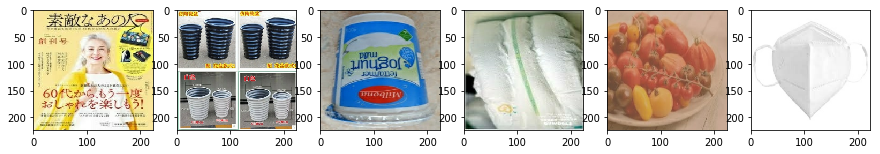

pre:牙刷 	true;卫生纸
pre:卫生纸 	true;卫生纸
pre:口服液瓶 	true;口服液瓶
pre:易拉罐 	true;易拉罐
pre:打火机 	true;打火机
pre:果蔬 	true;果蔬


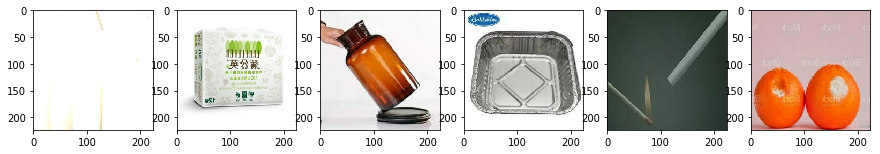

pre:衣服 	true;衣服
pre:棉签 	true;卫生纸
pre:口服液瓶 	true;口服液瓶
pre:电池 	true;电池
pre:口服液瓶 	true;口服液瓶
pre:打火机 	true;打火机


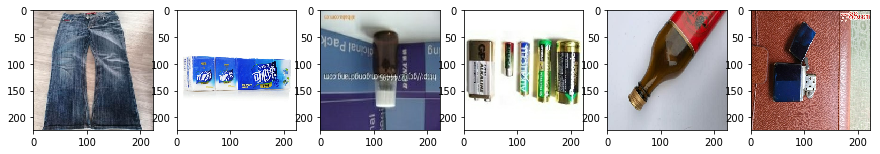

pre:鞋 	true;鞋
pre:纸箱 	true;纸箱
pre:牙刷 	true;牙刷
pre:电池 	true;易拉罐
pre:玻璃 	true;玻璃
pre:纸箱 	true;纸箱


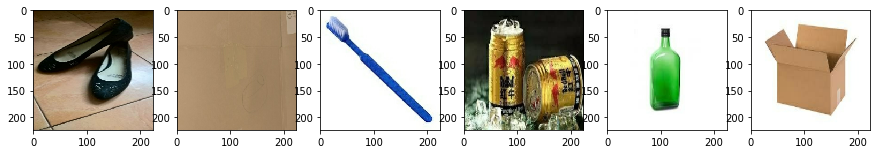

pre:废弃灯泡 	true;废弃灯泡
pre:鞋 	true;鞋
pre:口服液瓶 	true;易拉罐
pre:花盆 	true;花盆
pre:玻璃 	true;玻璃
pre:花盆 	true;花盆


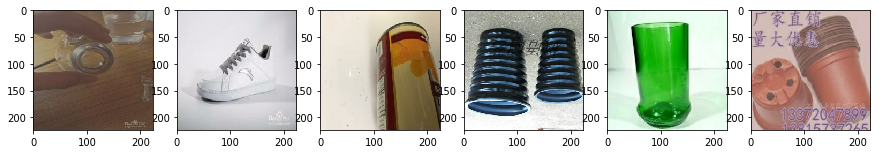

0.8333333333333334


In [10]:
# 查看预测效果

for images, labels in test_dataset.batch(batch_size): 
    width,height = 6,math.ceil(batch_size/6.0)
    acc=0
    output = model(images)
    for i in range(height):
        plt.figure(figsize=(15, 15))
        for j in range(width):
            plt.subplot(1,width,j+1)
#             print(output[i*width+j].numpy())
            index = tf.math.argmax(output[i*width+j]).numpy()
#             print(index)
            true = labels[i*width+j].numpy()
            if index == true:
                acc+=1
            print('pre:%s \ttrue;%s'%(class_names[index],class_names[true]))
#             plt.title(class_names[index]+' ('+class_names[true]+')')
            plt.imshow(images[i*width+j].numpy())
            if i*width+j == batch_size-1:
                    break
        plt.show()
    print(acc/batch_size)
    break

In [21]:
model.save_weights('weights/mobilenetv3l',save_format='h5')

In [ ]:
model.